In [70]:
import numpy as np
import sys, os
import _maps as maps
import _wavelets as wt

import healpy as hp
import astropy_healpix

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.stats import norm, uniform
from scipy.integrate import quad

from tqdm import tqdm

(-1.0, 1.0)

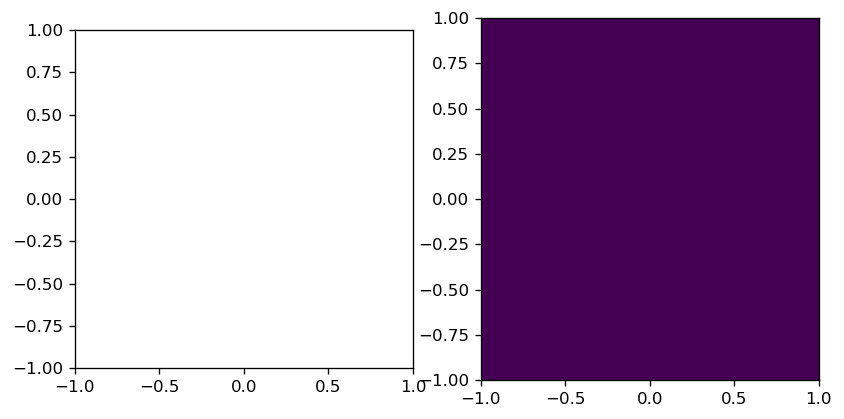

In [55]:
nm = norm(scale = 0.1, loc = 0)
x_data = nm.rvs(size = 0)
y_data = nm.rvs(size = 0)

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

(-1.0, 1.0)

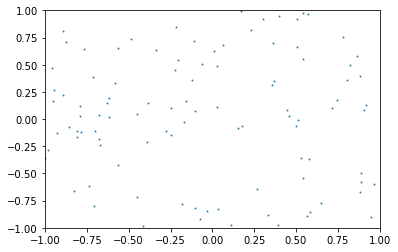

In [62]:
# "uniform distribution"

N_data = 100

uni = uniform(loc = -1, scale = 2)
N_uni = N_data
x_uni = uni.rvs(size = int(N_uni))
y_uni = uni.rvs(size = int(N_uni))

x_data = np.concatenate((x_data, x_uni))
y_data = np.concatenate((y_data, y_uni))

plt.scatter(x_uni, y_uni, s = 0.8)
plt.xlim([-1,1])
plt.ylim([-1,1])

In [63]:
bx_min, bx_max, by_min, by_max = [-1, 1,
                                  -1, 1]

scale = 0.1
step_size = scale 
mesh_bxby, arr_b, arr_bx_plot, arr_by_plot = maps.build_mesh_(bx_min, bx_max, by_min, by_max, step_size, step_size, return_arrays_for_plotting=True)
arr_bx = 0.5*(arr_bx_plot[1:] + arr_bx_plot[:-1])
arr_by = 0.5*(arr_by_plot[1:] + arr_by_plot[:-1])

(-1.0, 1.0)

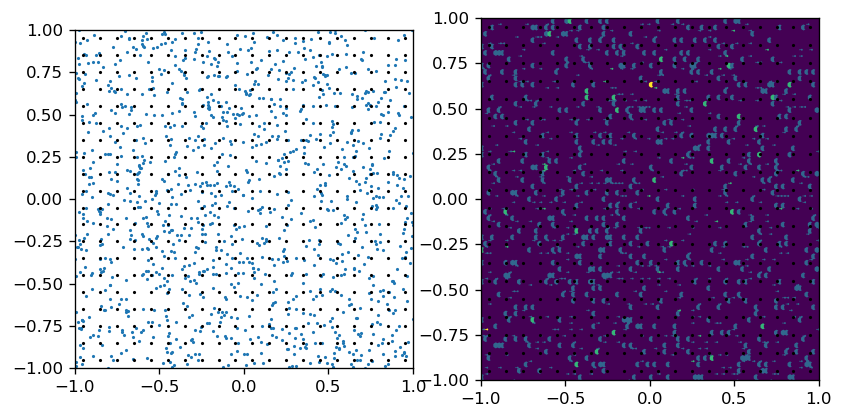

In [64]:
fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [65]:
# copy/paste from skysearch/generate_wavelet_coefficients.py

# load scale parameter
a = 0.1
arr_a = np.array([a])
Na = len(arr_a)

# define 2d wavelet
wavelet_name = 'mexh'
mexh = wt._2d_wavelet(wavelet_name)

# pre-allocate wavelet coefficient map 
data = np.stack([x_data, y_data], axis = -1)
N_data, N_dim = data.shape
Ny, Nx = mesh_bxby.shape[:-1]
cwt_map = np.zeros((Ny, Nx, 1))

# broadcast arrays in wavelet calculation
buf_data = data[np.newaxis,np.newaxis,np.newaxis]
buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

# calculate arguments of wavelet coefficients
# buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

# calculate wavelet coefficients
buf_mexh_output = mexh.base_fct(buf_arr_arg)

# remove two dimensions of a-array to divide mexh
buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

# estimate wavelet coefficient by summing over datapoints
buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq 
buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

# copy wavelet coefficient map to output array
cwt_map[:,:,0] = buf_cwt_map[:,:,0]

(-1.0, 1.0)

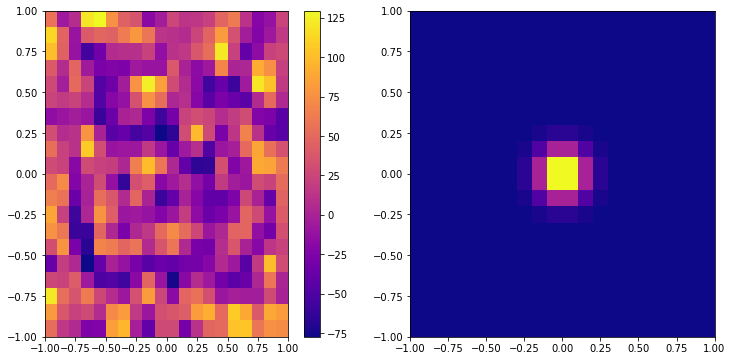

In [66]:
# compare to Gaussian 

# evaluate norm pdf at each grid point
output_pdf = np.zeros((len(arr_bx), len(arr_by)))
for nx in range(len(arr_bx)):
    for ny in range(len(arr_by)):
        output_pdf[nx,ny] = nm.pdf(arr_bx[nx]) * nm.pdf(arr_by[ny]) 

fig = plt.figure(1,figsize=(12,6))
ax = fig.add_subplot(121)

plot = plt.pcolormesh(arr_bx_plot, arr_by_plot, cwt_map[:,:,0], cmap='plasma', shading='flat'
                     , norm=mpl.colors.Normalize(vmin=np.min(cwt_map[:,:,0]), 
                                                 vmax=np.max(cwt_map[:,:,0])))
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
plt.colorbar(plot)

ax = fig.add_subplot(122)
ax.pcolormesh(arr_bx_plot, arr_by_plot, output_pdf, cmap='plasma', shading='flat')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

(-1.0, 1.0)

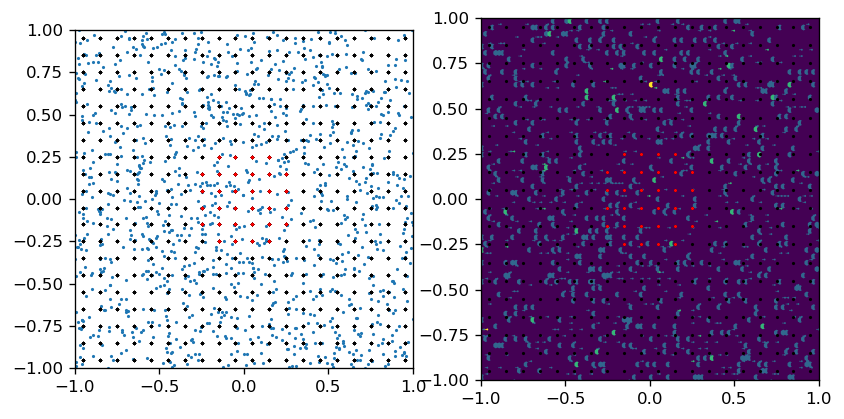

In [67]:
relative_positions = mesh_bxby - np.array([0,0])
distances = np.linalg.norm(relative_positions, axis = -1)
near = ( distances < np.sqrt(0.3**2 + 0.1**2) )

fig = plt.figure(figsize=(8, 4), dpi= 120)
ax = fig.add_subplot(121)
ax.set_aspect('equal')

ax.scatter(x_data, y_data, s = 0.8)
for n in range(Nx):
    ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
    ax.scatter(mesh_bxby[near][:,0], mesh_bxby[near][:,1], s = 0.8, c = 'r')

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

ax = fig.add_subplot(122)
ax.hexbin(x_data,y_data, gridsize = 100, extent = [-1,1,-1,1])
ax.scatter(arr_b[:,0], arr_b[:,1], s = 0.8, c = 'k')
ax.scatter(mesh_bxby[near][:,0], mesh_bxby[near][:,1], s = 0.8, c = 'r')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])

In [88]:
# calculate cwt for a faint point source and see how it is related to number of counts

cwt_map_list = []
counts_list = []
cwt_flat_near_list = []
counts_flat_near_list = []

for n in range(1000):
    N_data = 100

    uni = uniform(loc = -1, scale = 2)
    N_uni = N_data
    x_data = uni.rvs(size = int(N_uni))
    y_data = uni.rvs(size = int(N_uni))

    # load scale parameter
    a = 0.1
    arr_a = np.array([a])
    Na = len(arr_a)

    # define 2d wavelet
    wavelet_name = 'mexh'
    mexh = wt._2d_wavelet(wavelet_name)

    # pre-allocate wavelet coefficient map 
    data = np.stack([x_data, y_data], axis = -1)
    N_data, N_dim = data.shape
    Ny, Nx = mesh_bxby.shape[:-1]
    cwt_map = np.zeros((Ny, Nx, 1))

    # broadcast arrays in wavelet calculation
    buf_data = data[np.newaxis,np.newaxis,np.newaxis]
    buf_mesh_bxby = mesh_bxby[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_a = arr_a[np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    # calculate arguments of wavelet coefficients
    # buf_grid = grid[:,:,np.newaxis,np.newaxis,np.newaxis]
    buf_arr_arg =  ( (buf_data - buf_mesh_bxby ) / buf_arr_a )

    # calculate wavelet coefficients
    buf_mexh_output = mexh.base_fct(buf_arr_arg)

    # remove two dimensions of a-array to divide mexh
    buf_arr_a_sq = np.squeeze(buf_arr_a, axis = -1)
    buf_arr_a_sq = np.squeeze(buf_arr_a_sq, axis = -1)

    # estimate wavelet coefficient by summing over datapoints
    buf_cwt_map = np.sum(buf_mexh_output, axis = -1) / buf_arr_a_sq 
    buf_cwt_map = np.squeeze(buf_cwt_map, axis = -1)

    # copy wavelet coefficient map to output array
    cwt_map[:,:,0] = buf_cwt_map[:,:,0]
    cwt_map_list.append(cwt_map)

    x_data = data[:,0] ; y_data = data[:,1]
    counts, xedges, yedges = np.histogram2d(x_data, y_data, bins = [arr_bx_plot, arr_by_plot])
    counts_list.append(counts)

    cwt_flat_near = cwt_map[:,:,0][near].flatten('C')
    counts_flat_near = counts[near].flatten('C')

    cwt_flat_near_list.append(cwt_flat_near)
    counts_flat_near_list.append(counts_flat_near)

In [89]:
for n in tqdm(range(1000)):
    cwt_map = cwt_map_list[n]
    counts = counts_list[n]

    counts_flat = counts.flatten('C')
    cwt_flat = cwt_map[:,:,0].flatten('C')

    cwt_flat_near = cwt_flat_near_list[n]
    counts_flat_near = counts_flat_near_list[n]

    if n == 0:
        counts_flat_list = counts_flat
        cwt_flat_list = cwt_flat
        counts_flat_near_single = counts_flat_near
        cwt_flat_near_single = cwt_flat_near
    else:
        counts_flat_list = np.concatenate((counts_flat_list, counts_flat))
        cwt_flat_list = np.concatenate((cwt_flat_list, cwt_flat))
        counts_flat_near_single = np.concatenate((counts_flat_near_single, counts_flat_near))
        cwt_flat_near_single = np.concatenate((cwt_flat_near_single, cwt_flat_near))

100%|██████████| 1000/1000 [00:00<00:00, 2814.75it/s]


Text(0, 0.5, 'Wavelet Coefficient')

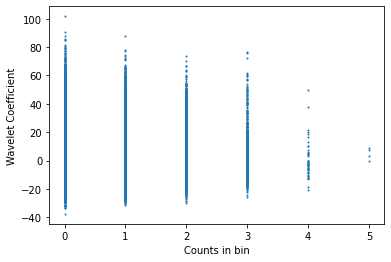

In [90]:
from scipy.stats import gaussian_kde

counts_flat = counts.flatten('C')
cwt_flat = cwt_map[:,:,0].flatten('C')

fig, ax = plt.subplots()
ax.scatter(counts_flat_list, cwt_flat_list, s = 1)
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')

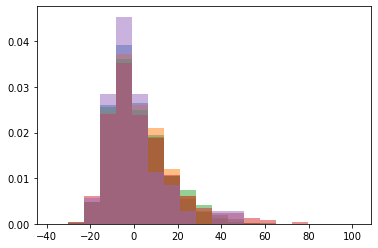

In [91]:
cwt_bins = np.linspace(np.min(cwt_flat_list), np.max(cwt_flat_list), 20)

cwt_flat_n_list = []
cwt_flat_list_binned = []
for n in range(int(np.max(counts_flat_list))):
    cwt_flat_n = cwt_flat_list[counts_flat_list==n]
    cwt_flat_n_list.append(cwt_flat_n)
    cwt_counts, bins, _ = plt.hist(cwt_flat_n, bins = cwt_bins, density = True, alpha = 0.5)
    cwt_flat_list_binned.append(cwt_counts)

Number of Data Points within Each Group:
----------------------------------------
Counts in Bin: [0 1 2 3 4]
Number of Data Points: [311365  78214   9533    836     48]


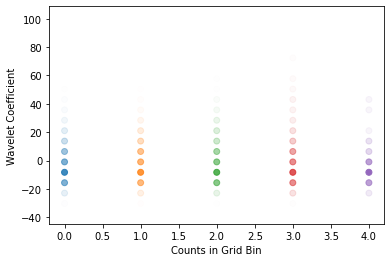

In [92]:
fig, ax = plt.subplots()

for n in range(int(np.max(counts_flat_list))):
    counts_flat_n = counts_flat_list[counts_flat_list==n]
    ax.scatter(n * np.ones(len(cwt_bins)), cwt_bins, alpha = cwt_flat_list_binned[n] / np.max(cwt_flat_list_binned), label = str(n))
    ax.set_xlabel('Counts in Grid Bin')
    ax.set_ylabel('Wavelet Coefficient')

print('Number of Data Points within Each Group:')
print('----------------------------------------')
print('Counts in Bin: ' + str(np.arange(int(np.max(counts_flat_list)))))
print('Number of Data Points: ' + str(np.array([len(counts_flat_list[counts_flat_list==n]) for n in range(int(np.max(counts_flat_list)))])))

Text(0, 0.5, 'Wavelet Coefficient')

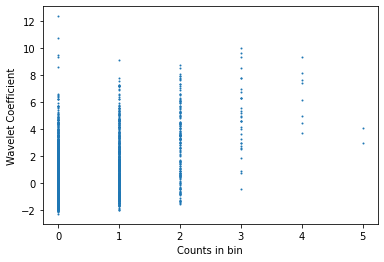

In [77]:
from scipy.stats import gaussian_kde

fig, ax = plt.subplots()
ax.scatter(counts_flat_near_single, cwt_flat_near_single, s = 1)
ax.set_xlabel('Counts in bin')
ax.set_ylabel('Wavelet Coefficient')